The purpose of this notebook is to evaluate and diagnose our initial attempt at a object detection model to detect stations in our game frames.

This is a single class detector (station). Labels were also created for the individual station shapes but the performance of this was very bad (likely due to imbalanced classes) and so this version is on hold until we get an acceptable result with a single class.

We are implementing the pre-trained **ssd_mobilenet_v1** architecture, and only re-training the final fully connected layer.

In [1]:
cd ..

C:\Users\macle\Dropbox\mcode\SerpentAI


In [37]:
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detection import ObjectDetector, draw_bounding_box
import tensorflow as tf
import skimage.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [4]:
frozen_graph_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_frozen_graph.pb"
labels_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_label_map.json"

In [5]:
station_detector = ObjectDetector(frozen_graph_path, labels_path)

### Running inference and plotting results on 'test' images

(by default we only show predictions with a probability > 0.5, but we can change this if we like)

In [28]:
img_paths = list(Path("ml_train/station_detector/data/test").glob("*.png"))
img_filenames = [img_path.name for img_path in img_paths]

In [7]:
%%time
images = [skimage.io.imread(img_path) for img_path in img_paths]

detection_results = [station_detector.run_detection(image) for image in images] 

Wall time: 56.5 s


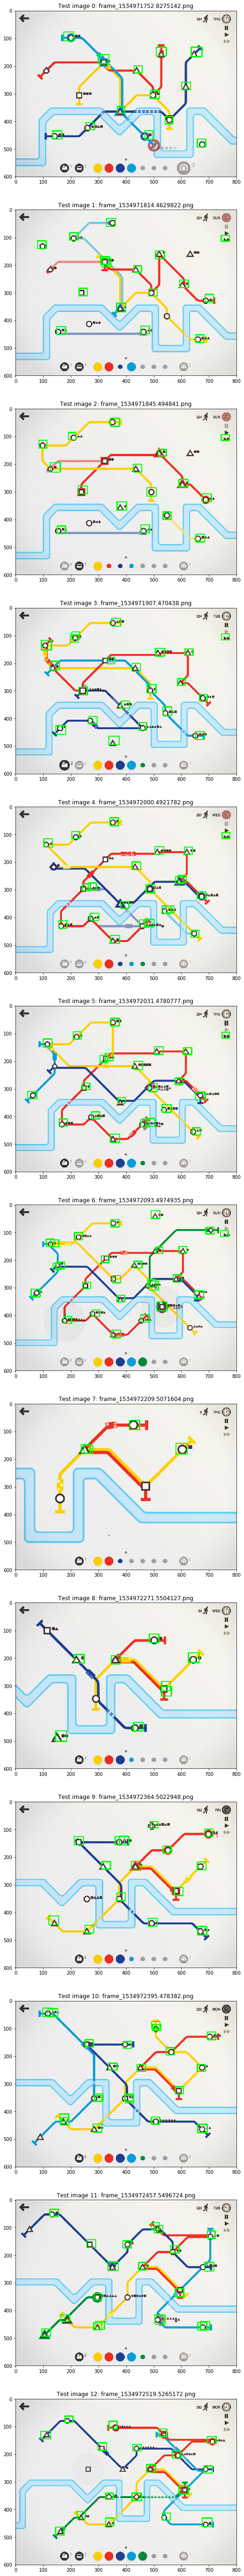

In [33]:
_, axes = plt.subplots(nrows=len(detection_results), ncols=1, figsize=(15,100))

for i, (image, img_filename, detection_result, ax) in enumerate(zip(images, img_filenames, detection_results, axes.flat)):
    image_box = station_detector.draw_bounding_boxes(image, **detection_result) 
    ax.imshow(image_box)
    ax.set_title(f"Test image {i}: {img_filename}")

A visual inspection of the performance on the test data shows that it is working well (still need to define function to return MAP metric), but there are some stations that it is missing completely.

### Possible explanations for accuracy issues

* **Not enough training data**: we only use around 50 training images which is relatively small, however the task we are trying to peform feels quite constrained so I would not expect it to require a lot of data. In any case there appears to be some near identical cases where a correct predictions is made for one image, and not for ther other. For example the triangle station on the dark blue line at the left of images 11/12 is captured correctly in one case and not the other.
* **Transfer learning not appropriate for this task:** This model was initially trained on the COCO dataset which contains photographic images, whereas we are dealing with relatively simple vector-based graphics. Perhaps the features learnt are not appropriate enough for our new task and we would be better off re-training all layers of the CNN model (but still using the existing model for our initialized weights.
* **Shape requirements of models lead to poor resolution:** The model currently requires an input size of 300x300 so the images are compressed into this shape. Perhaps the loss of resolution, aspect if affecting performance.
* **SSD model typically performs less well on small objects**: Need to investigate this, only anecdotal at this stage

Or something else altogether...